In [10]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 119 kB/s  eta 0:00:01
     |████████████████████████████████| 198 kB 28.8 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=992dd10dbb61edf8a9fe2e65997c11d7ae36c916ed935549b636370d3613cf7f
  Stored in directory: /Users/yishanli/Library/Caches/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as fc

In [2]:
long_data = pd.read_csv('../project_data/oasis_longitudinal.csv')
#cross_data = pd.read_csv('../project_data/oasis_cross-sectional.csv')

In [3]:
long_data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
# Drop the Hand because it's all right, other factors are irrelevent to the target
data = long_data.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand'])

In [5]:
# Change gender to numeric value
data['gender'] = np.where(data['M/F'] == 'M', 0, 1)
data = data.drop(columns=['M/F'])

In [6]:
# data imputation, since there are missing value in the SES, we will use data imputation
data

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,gender
0,Nondemented,87,14,2.0,27.0,0.0,1987,0.696,0.883,0
1,Nondemented,88,14,2.0,30.0,0.0,2004,0.681,0.876,0
2,Demented,75,12,NaN,23.0,0.5,1678,0.736,1.046,0
3,Demented,76,12,NaN,28.0,0.5,1738,0.713,1.010,0
4,Demented,80,12,NaN,22.0,0.5,1698,0.701,1.034,0
...,...,...,...,...,...,...,...,...,...,...
368,Demented,82,16,1.0,28.0,0.5,1693,0.694,1.037,0
369,Demented,86,16,1.0,26.0,0.5,1688,0.675,1.040,0
370,Nondemented,61,13,2.0,30.0,0.0,1319,0.801,1.331,1
371,Nondemented,63,13,2.0,30.0,0.0,1327,0.796,1.323,1


In [7]:
data['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

In [8]:
# Drop the converted case
data = data[data.Group != 'Converted']
data = data.reset_index(drop=True)
data

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,gender
0,Nondemented,87,14,2.0,27.0,0.0,1987,0.696,0.883,0
1,Nondemented,88,14,2.0,30.0,0.0,2004,0.681,0.876,0
2,Demented,75,12,NaN,23.0,0.5,1678,0.736,1.046,0
3,Demented,76,12,NaN,28.0,0.5,1738,0.713,1.010,0
4,Demented,80,12,NaN,22.0,0.5,1698,0.701,1.034,0
...,...,...,...,...,...,...,...,...,...,...
331,Demented,82,16,1.0,28.0,0.5,1693,0.694,1.037,0
332,Demented,86,16,1.0,26.0,0.5,1688,0.675,1.040,0
333,Nondemented,61,13,2.0,30.0,0.0,1319,0.801,1.331,1
334,Nondemented,63,13,2.0,30.0,0.0,1327,0.796,1.323,1


In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [55]:
# imputation on the whole dataset as there are limited amount of observations
impt = data.iloc[:,1:]
impt

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,gender
0,87,14,2.0,27.0,0.0,1987,0.696,0.883,0
1,88,14,2.0,30.0,0.0,2004,0.681,0.876,0
2,75,12,NaN,23.0,0.5,1678,0.736,1.046,0
3,76,12,NaN,28.0,0.5,1738,0.713,1.010,0
4,80,12,NaN,22.0,0.5,1698,0.701,1.034,0
...,...,...,...,...,...,...,...,...,...
331,82,16,1.0,28.0,0.5,1693,0.694,1.037,0
332,86,16,1.0,26.0,0.5,1688,0.675,1.040,0
333,61,13,2.0,30.0,0.0,1319,0.801,1.331,1
334,63,13,2.0,30.0,0.0,1327,0.796,1.323,1


In [57]:
imp = IterativeImputer(max_iter=10, random_state=57)
imp_data = imp.fit_transform(impt)

In [62]:
impt_data = pd.DataFrame(imp_data, columns = impt.columns)
impt_data['Group'] = data['Group']
impt_data

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,gender,Group
0,87.0,14.0,2.000000,27.0,0.0,1987.0,0.696,0.883,0.0,Nondemented
1,88.0,14.0,2.000000,30.0,0.0,2004.0,0.681,0.876,0.0,Nondemented
2,75.0,12.0,3.168473,23.0,0.5,1678.0,0.736,1.046,0.0,Demented
3,76.0,12.0,3.096041,28.0,0.5,1738.0,0.713,1.010,0.0,Demented
4,80.0,12.0,3.134898,22.0,0.5,1698.0,0.701,1.034,0.0,Demented
...,...,...,...,...,...,...,...,...,...,...
331,82.0,16.0,1.000000,28.0,0.5,1693.0,0.694,1.037,0.0,Demented
332,86.0,16.0,1.000000,26.0,0.5,1688.0,0.675,1.040,0.0,Demented
333,61.0,13.0,2.000000,30.0,0.0,1319.0,0.801,1.331,1.0,Nondemented
334,63.0,13.0,2.000000,30.0,0.0,1327.0,0.796,1.323,1.0,Nondemented


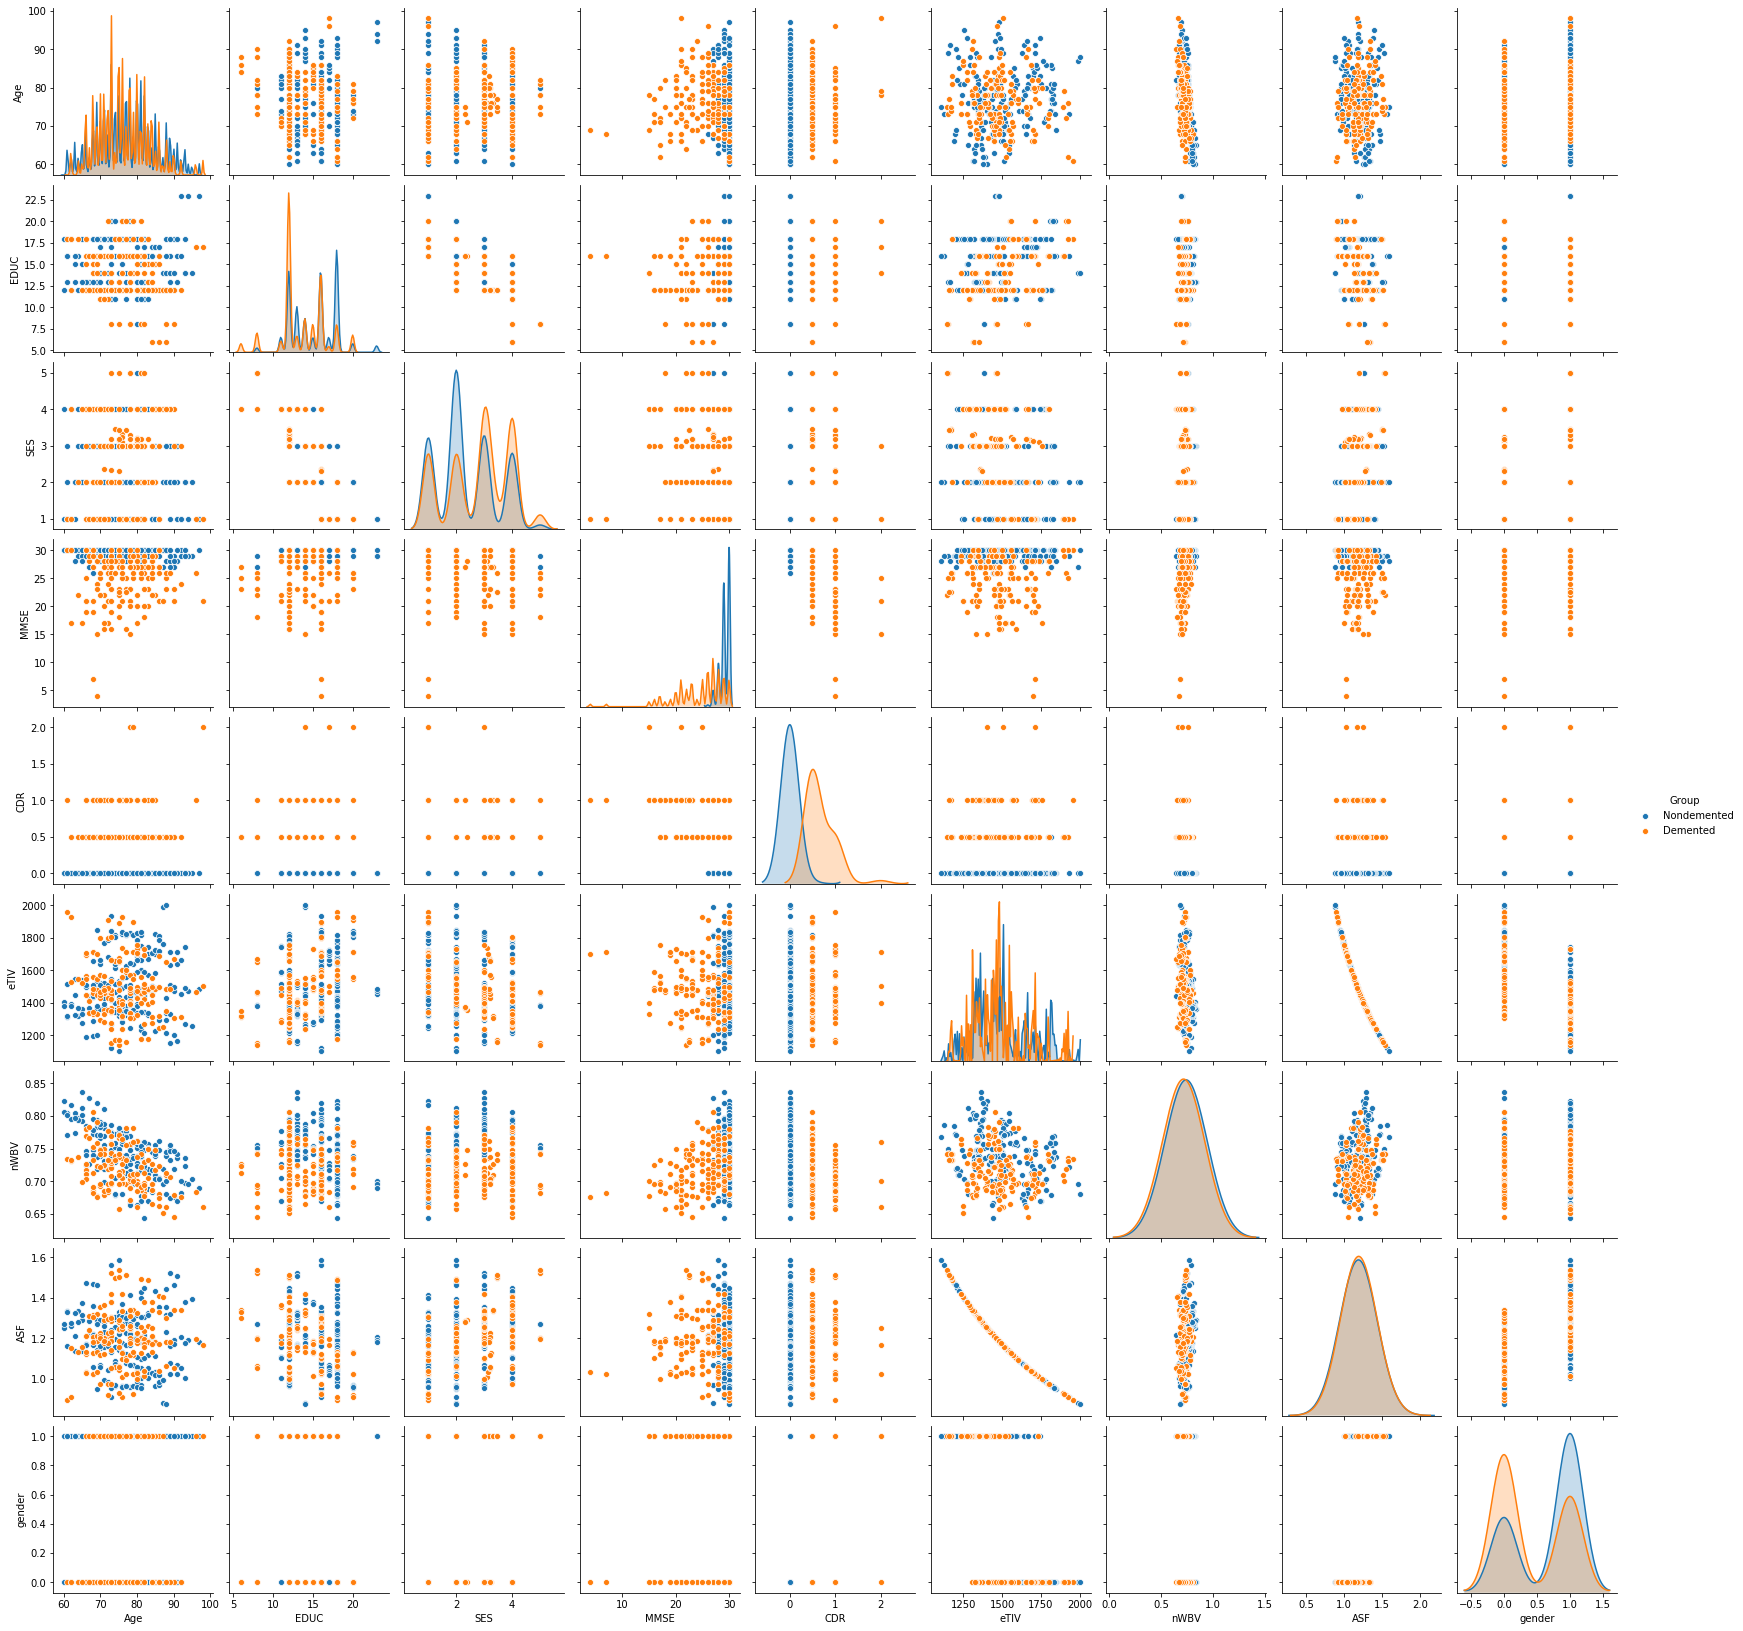

In [64]:
sns.pairplot(impt_data, hue = 'Group', diag_kws={'bw': 0.2})

In [82]:
# split data into test and train dataset
train_X = impt_data.iloc[:235,:-1]
train_y = impt_data.iloc[:235,-1]

train_X = impt_data.iloc[235:,:-1]
train_y = impt_data.iloc[235:,-1]

train = impt_data.iloc[:235,:]
test = impt_data.iloc[235:,:]

In [84]:
# To json

In [83]:
import json

In [87]:
train_rlt = train.to_json(orient="records")

In [91]:
test_rlt = test.to_json(orient="records")

In [88]:
import requests

In [89]:
url1 = 'https://finalproject-42236-default-rtdb.firebaseio.com/train.json'

In [92]:
url2 = 'https://finalproject-42236-default-rtdb.firebaseio.com/test.json'

In [90]:
r1 = requests.put(url1, train_rlt)

In [93]:
r2 = requests.put(url2, test_rlt)